<a href="https://colab.research.google.com/github/nehdiii/greek_gods_status_recognition_useing_siamese_networks/blob/main/siamese_triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train Siamese network to recognize greek gods statues

##What is a Siamese Neural Network ?

a Siamese Neural Network is ***any*** ***model*** ***architecture***  which contains at least two parallel identical Convolutional Neural Networks

 This CNN architecture allows for the model to learn similarity which can be used instead of a direct classification



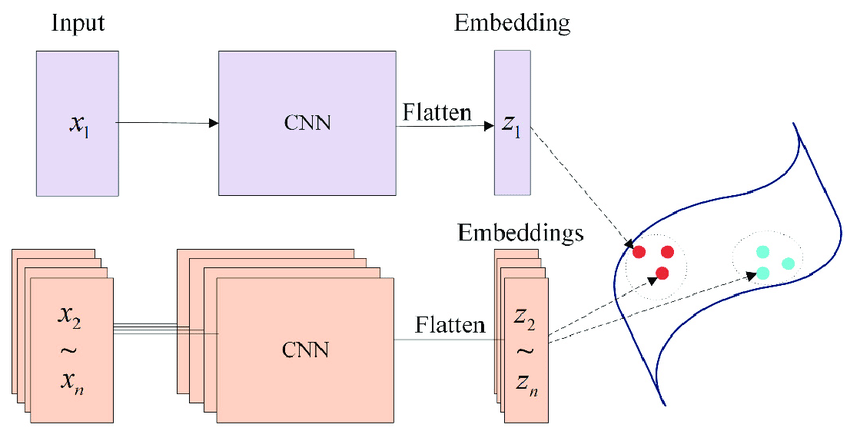

Each parallel CNN designed to produce an embedding

For example :

  image of size ***width*** * ***height*** * ***channels***  ==== output ===> ***vector*** of size 10 which directly represents the image

These embeddings can then be used to optimise a Loss, and at test time used to generate a similarity score for prediction 

The parallel CNNs can take any form but One important point however is that they must be :  


1.   completely identical
2.   share the same architecture
3.   share the same initial and updated weights
4.   have the same hyperparameters


More recent versions of SNNs will most likely utilise triple or even quadruple branching containing three or four parallel CNNs respectively we will use the triplet aproche



 

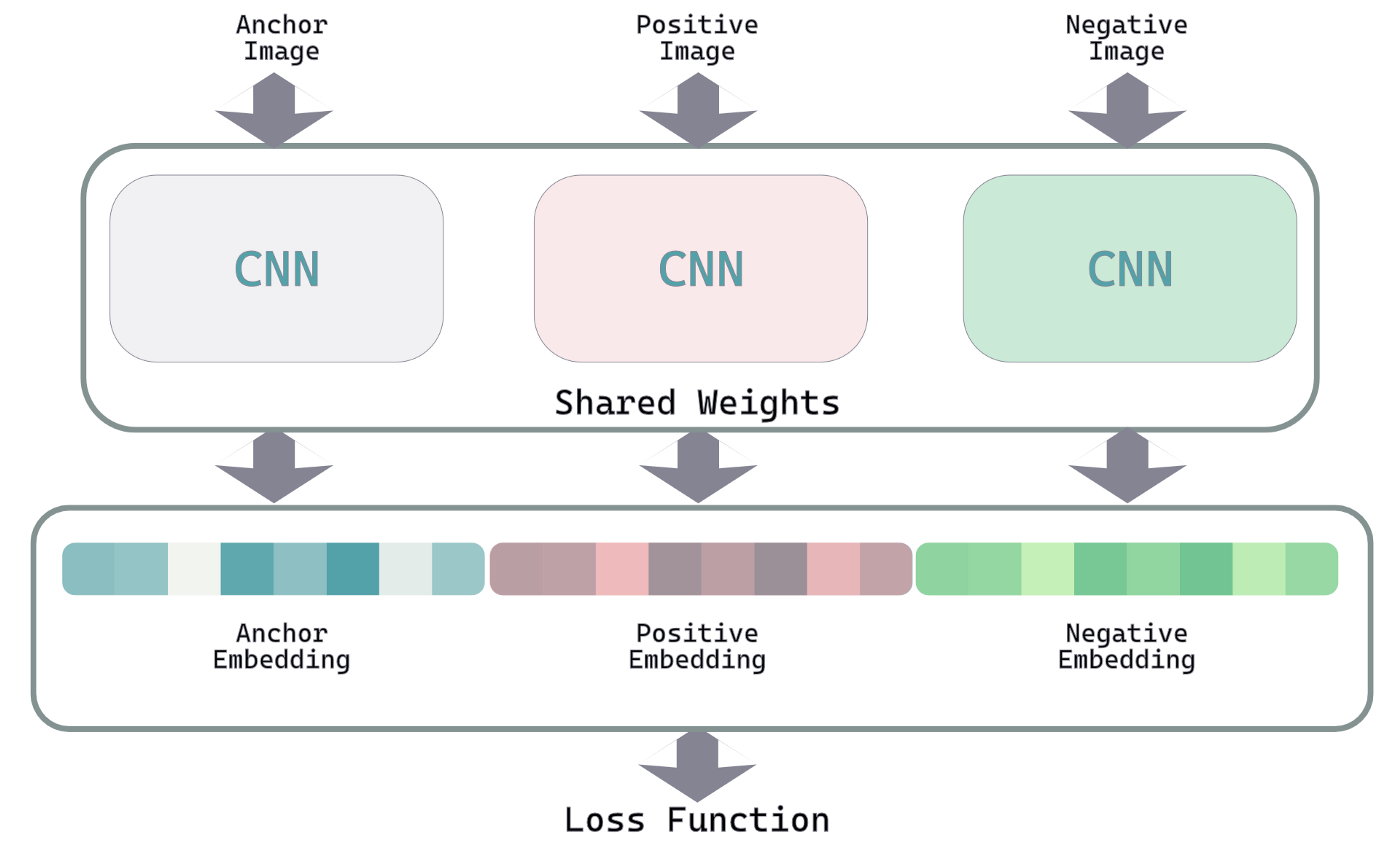

##how Siamese Neural Network(SNN) learn and what they do 

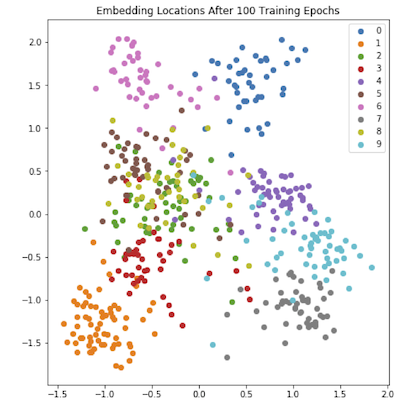

Using the generated d-dimensional embeddings 
we can create some d-dimensional space that allows the embeddings to be plotted creating clusters This space can then be projected down to 2-dimensions for plotting using Principle Component Analysis or PCA

This plot in the top shows the embedding locations for a subsets of 10 diffrent class  of images Notice how even after long training (many epochs) the model is starting to generate similar embeddings for images of the same class




##Model Training

 SNNs consist of at least two parallel CNN branches but modern implementations often rely on more The number of branches in SNN has a big influence on model training more over but the choice of loss function must also take the number of branches into account



Ranking Losses also known as Contrastive Losses aim to predict relative distances between model inputs when projected onto a space. This is in comparison to more traditional losses which aim to predict some set of class labels 

Lets say we have two inputs, and we want to know how similar they are using a Ranking Loss we would perform the following steps:



1.   extract the features from the input
2.   embed the extracted features onto a d-dimensional space
3.   calculate the distance between the embeddings (euclidean distance) to be used as a measure of similarity







##Triplet Ranking Loss Approach

pne of the more common types of Ranking Loss used for SNNs is Triplet Ranking Loss 

Triplet Ranking Loss requires three inputs which we call a triplet 

###The Anchor 
####is data of some class X which defines which class the triplet will train the model on
###The Positive
####is another example of the class X
###The Negative
####is a data of some class which is not X

At train time each of our triplet components is fed to its own CNN branch to be embedded

These embeddings are passed to the Triplet Loss



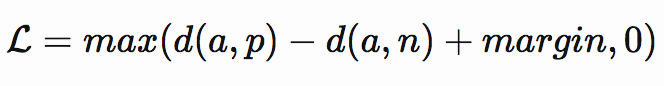

* d(a,p): is the distance between the anchor and the positive data 
* d(a,n) : is the distance between the anchor and the negative data 
* margin : small value used when d(a,p) is close to d(a,n) 
* d(v1,v2) = norm2(v1-v2) !!! 
* we always need to make sure thart d(a,p) + margin < d(a,n)  == > d(a,p) - d(a,n)+ margin < 0 


The purpose of this function is to minimise the distance between the Anchor and the Positive while maximising the distance between the Anchor and the Negative

##Semi-Hard Triplet Mining

it is important that our SNN is provided only with triplets which will enable it to learn

we want to provide Negatives such that our triplets allow the model to learn
but not be so difficult that learning takes too long An easy way to do this is through a process known as ***Semi-Hard*** ***Triplet*** ***Mining***


let's define three categories of triplet :

* **Easy Triplets** are those where d(a,p) + margin < D(a,n), thus Loss = 0
* **Hard Triplets** are those where d(a,n) < d(a,p)
* **Semi-Hard Triplets** are those where d(a,p) < D(a,n) < D(a,p) + margin


The goal is to find as many Semi-Hard Triplets as possible

These triplets have a positive loss but the positive embedding distance is closer to the anchor embedding than the negative. This allows for fast training but is still difficult enough for the model to actually learn something during training


Finding these Semi-Hard triplets can be performed in one of two ways: 
* **Offline mining** the entire dataset is converted into triplets before training
* **Online mining** batches of data are fed in with random triplets generated on the fly





##Using SNNs at Test Time

SNNs are trained during training we used all of the branches of the SNN whereas test can be performed using a single CNN branch 


the input image of an unknown class is processed by the CNN branch and has its features embedded his embedding is then compared with the other clusters This provides us with a list of similarity scores


##1-Importing packages

In [1]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt

target_shape = (300, 300)

##2-Importing data

 we need to import a dataset for our SNN to work with i collected some status from google the work with 5 status i will use ImageDataGenerator to load data 
from drive the data is splited into train and test folder


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# initialization of train and test data generators also i added some attributs for data augmentation when loading (bcz we have lake of data)
# all images will be rescaled by 1./255 and i did some data augmentation in the train 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [4]:

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/PCD_data/training',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=400,
        class_mode='sparse',
)
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/PCD_data/testing',  # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=100,
        class_mode='sparse')

Found 1200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


now we split our data to x_train y_train / x_test y_test

In [5]:

(X_train, y_train) = next(train_generator)
(X_test, y_test) = next(validation_generator)

##3-Create the triplets

``create_batch()`` generates triplets by randomly selecting two class labels one for the Anchor/Positive and one for the Negative 

In [6]:
def create_batch(batch_size=256, split = "train"):
    """
      input :
        batch_size : size of random batch 
        split : data  set we batch from 
      output:  batch of  random triplets 
    """
    # zeroed matrices that well conatine our anchor positive and  negative 
    x_anchors = np.zeros((batch_size,300,300,3))
    x_positives = np.zeros((batch_size, 300,300,3))
    x_negatives = np.zeros((batch_size, 300,300,3))
    # the data set will take our triplet from 
    if split =="train":
        data = X_train
        data_y = y_train
    else:
        data = X_test
        data_y = y_test
    # loop over  batches size and select 
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, data.shape[0] - 1) # selecting a random index from data set 
        x_anchor = data[random_index] #retrive the randomly selected image  and its label 
        y = data_y[random_index] # retrive the label 
        
        indices_for_pos = np.squeeze(np.where(data_y == y)) #use np.where to select all indecies with label similar to the anchor 
        indices_for_neg = np.squeeze(np.where(data_y != y)) #use np.where to select all incdecies with label not similar to the anchor  

        x_positive = data[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]] #select random positive indice and then the image 
        x_negative = data[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]] # same 
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        # update and return the triplet in the format (3,300,300,3)
    return [x_anchors, x_positives, x_negatives]



``create_hard_batch()`` creates a batch of random triplets using ``create_batch()`` and embeds them using the current SNN This allows us to determine which triplets in the batch are Semi-Hard if they are we keep num_hard of them populating the rest of the batch with other random triplets By padding with random triplets we allow for training to begin as well as ensure our batches are of a consistent size



In [7]:


def create_hard_batch(batch_size, num_hard, split = "train"):
    
    x_anchors = np.zeros((batch_size,300,300,3))
    x_positives = np.zeros((batch_size,300,300,3))
    x_negatives = np.zeros((batch_size,300,300,3))
    
    if split =="train":
        data = X_train
        data_y = y_train
    else:
        data = X_test
        data_y = y_test
    # for  example we want batch of 100 triplets and num_hard = 20 so 100 = 20 hard batches and the rest is random 
    # Generate num_hard number of hard examples:
    hard_batches = [] 
    batch_losses = []
    
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1, split))
  
        
        A_emb = embedding.predict(hard_batches[i][0])
        P_emb = embedding.predict(hard_batches[i][1])
        N_emb = embedding.predict(hard_batches[i][2])
        
        # Compute d(A, P) - d(A, N) for each selected batch
        batch_losses.append(np.sum(np.square(A_emb-P_emb),axis=1) - np.sum(np.square(A_emb-N_emb),axis=1))
    
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses,hard_batches), key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1, split)
        rand_batches.append(rand_batch)
    
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i] = selections[i][0]
        x_positives[i] = selections[i][1]
        x_negatives[i] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]

##4-Defining the SNN

The SNN is defined in two parts First we must create the embedding model This model receives an input image and generates a d-dimensional embedding here i will use many examples of deep network and the pick the best will start with resnet50 and mobilenet v2 .. i will train the deep net with imagnet is pre-trained net that can classify 1000 classes also i blocked all the network 
(eg some trained layers) and activated some layers to train and adapt on our data "conv5_block1_out"

In [8]:

base_cnn = resnet.ResNet50(weights="imagenet", input_shape=target_shape + (3,), include_top=False,pooling="max")
#base_cnn = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", input_shape=(300,300,3), include_top=False,pooling='max')
#base_cnn = tf.keras.applications.MobileNetV3Large(weights="imagenet", input_shape=(300,300,3), include_top=False,pooling='max')

base_cnn.summary()
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Next we create a model which receives a triplet passes it to the embedding model sequentially for embedding then passes the resultant embeddings to the triplet loss function

In [9]:


class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.

    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    # call to make a callable class calculate d(a,p) and d(a,n) to use for the loss 
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [10]:
# the snn will take 3 inputs 
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

In [11]:
# the output of snn
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

In [12]:
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [13]:
class SiameseModel(Model):
    """The siamese network model with a custom training and testing loops

    Computes the triplet loss using the three embeddings produced by the
    siamese network

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    we will custom our loss and use the gradient tape to claluclate our backprops with tf 
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


this part i used for  debugging my model by ploting the embeddings prefromed in the test time to see how well the model splits the data its a callback used whil training 

In [14]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=False)

##5-training

In [15]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

in the training i used to triplet loss concept 

9/9 [==============================] - 14s 2s/step - loss: 0.4500 - val_loss: 0.4752


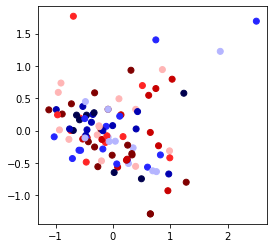

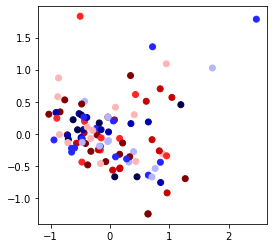

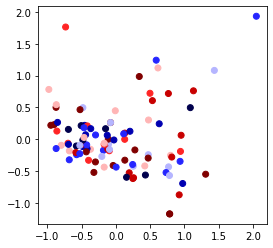

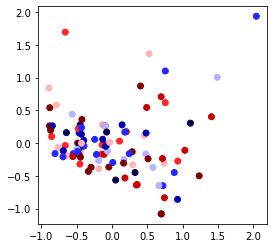

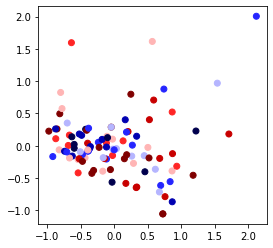

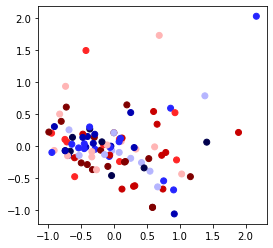

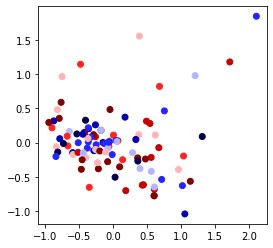

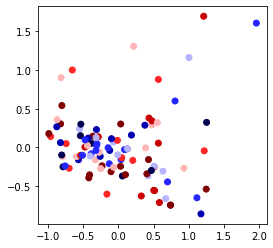

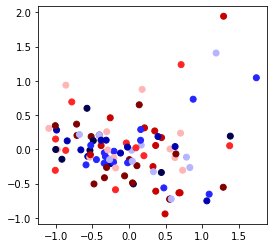

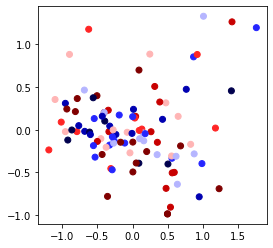

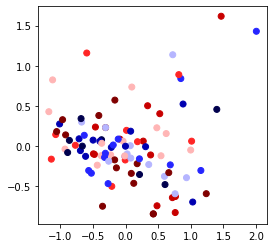

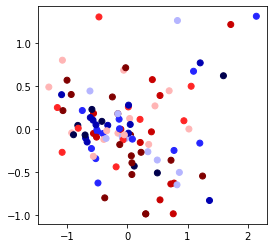

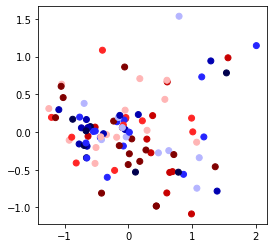

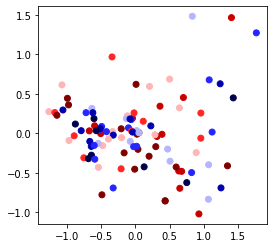

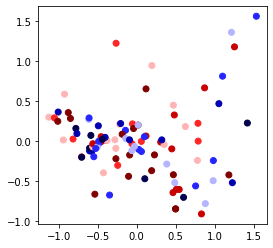

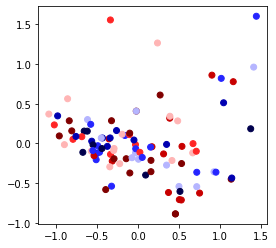

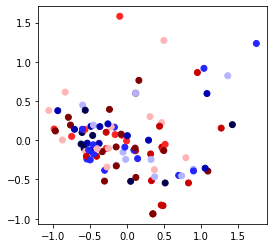

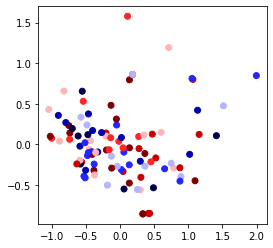

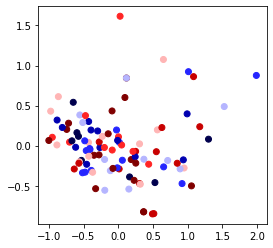

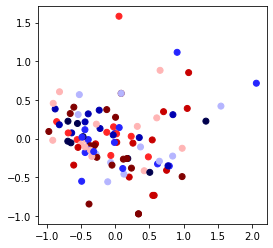

In [36]:
epochs = 20
for i in range(epochs):
  generate_train_data = create_hard_batch(100,50)
  generate_test_data = create_hard_batch(100,50,"test")
  siamese_model.fit(generate_train_data, epochs=1, steps_per_epoch = int(90/10) ,callbacks=[
          PCAPlotter(
              plt, embedding,
              X_test[:100], y_test[:100]
          )],
          validation_data = generate_test_data)
#look at pca plot how the model learning how to split data on each epoch end 

Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction.

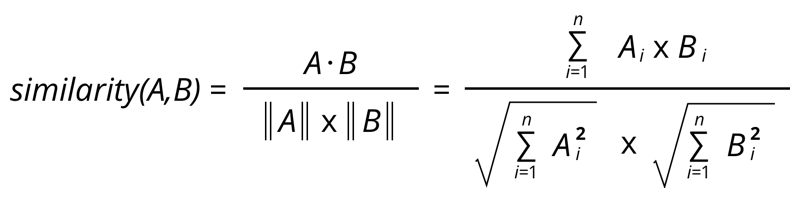

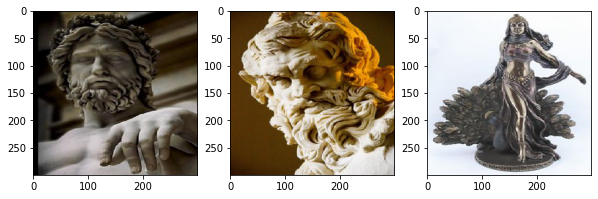



Positive similarity: 0.99960786 Negative similarity 0.9995176


In [55]:
# close to 1 the similarity is close the pics is 
cosine_similarity = metrics.CosineSimilarity()

print("\n")

random_sample = create_batch(1,'test')
_, axs = plt.subplots(1, 3, figsize=(10, 10))
for img,ax in zip(random_sample,axs):
   ax.imshow(img[0])
plt.show()
anchor, positive, negative = random_sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(tf.keras.applications.resnet50.preprocess_input(anchor)),embedding(tf.keras.applications.resnet50.preprocess_input(positive)),
    embedding(tf.keras.applications.resnet50.preprocess_input(negative)),
 )
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
negative_similarity =  cosine_similarity(anchor_embedding, negative_embedding)
print("\n")
print("Positive similarity:", positive_similarity.numpy(),"Negative similarity", negative_similarity.numpy())
 
 